# RFM Analysis

In [21]:
import random
import datetime
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('data_rfm.csv')
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

In [22]:
# Crear una variable con la fecha actual en el tipo datetime64[ns]
fecha_hoy = np.datetime64(datetime.date.today())

In [23]:
# Se crea una tabla agregada
tabla = df.groupby('CUSTOMER').agg({
    'ORDER_DATE': lambda x: (fecha_hoy - x.max()).days, #Los días que han pasado desde la compra hasta hoy
    'ORDER_ID': lambda x: len(x.unique()), #La cantidad de Compras en el periodo
    'GRAND_TOTAL': lambda x: x.sum() #La Suma total de las compras
})

# Proceso de Scoring

In [36]:
#Solo cambio los nombres para hacerlo más claro.
tabla.rename(columns={'ORDER_DATE': 'recency','ORDER_ID': 'frequency','GRAND_TOTAL': 'monetary_value'}, inplace=True)

#Se ordenan los datos en Cuantiles y se le da un "Scoring" a cada cliente
quantiles = tabla.quantile(q=[0.25,0.5,0.75], numeric_only=True)
quantiles = quantiles.to_dict()
tabla_rfm = tabla

def quartile_class(x, quartiles):
    if x <= quartiles[0.25]:
        return 4
    elif x <= quartiles[0.50]:
        return 3
    elif x <= quartiles[0.75]:
        return 2
    else:
        return 1

#Acá se aplican 3 columnas con el Scoring    
tabla_rfm['R_Quartile'] = tabla_rfm['recency'].apply(quartile_class, args=(quantiles['recency'],))
tabla_rfm['F_Quartile'] = tabla_rfm['frequency'].apply(quartile_class, args=(quantiles['frequency'],))
tabla_rfm['M_Quartile'] = tabla_rfm['monetary_value'].apply(quartile_class, args=(quantiles['monetary_value'],))

# Proceso de Segmentación

In [37]:
#Se configuran las condiciones. Agrega o quita las que quieras.
condiciones = [
    (tabla_rfm['R_Quartile'] < 4) & (tabla_rfm['F_Quartile'] <= 2) & (tabla_rfm['M_Quartile'] <= 2),
    (tabla_rfm['R_Quartile'] <= 2) & (tabla_rfm['F_Quartile'] >= 2) & (tabla_rfm['M_Quartile'] >= 2),
    ((tabla_rfm['R_Quartile'] == 2) | (tabla_rfm['R_Quartile'] == 3)) & (tabla_rfm['F_Quartile'] >= 3) & (tabla_rfm['M_Quartile'] >= 3),
    (tabla_rfm['R_Quartile'] >= 3) & (tabla_rfm['F_Quartile'] <= 3) & (tabla_rfm['M_Quartile'] <= 3),
    (tabla_rfm['R_Quartile'] <= 2) & (tabla_rfm['F_Quartile'] == 4) & (tabla_rfm['M_Quartile'] == 4),
    (tabla_rfm['R_Quartile'] == 1) & (tabla_rfm['F_Quartile'] == 1) & (tabla_rfm['M_Quartile'] == 1),
    (tabla_rfm['R_Quartile'] == 4) & (tabla_rfm['F_Quartile'] == 1) & (tabla_rfm['M_Quartile'] == 1),
    (tabla_rfm['R_Quartile'] == 1) & (tabla_rfm['F_Quartile'] == 4) & (tabla_rfm['M_Quartile'] == 4),
    ((tabla_rfm['R_Quartile'] == 2) | (tabla_rfm['R_Quartile'] == 3)) & ((tabla_rfm['F_Quartile'] == 2) | (tabla_rfm['F_Quartile'] == 3)) & ((tabla_rfm['M_Quartile'] == 2) | (tabla_rfm['M_Quartile'] == 3)),
    (tabla_rfm['R_Quartile'] == 4) & (tabla_rfm['F_Quartile'] == 4) & (tabla_rfm['M_Quartile'] == 4),
    (tabla_rfm['R_Quartile'] == 3) & (tabla_rfm['F_Quartile'] == 3) & (tabla_rfm['M_Quartile'] == 3)
]

#Se agregan los valores que se darán según las condiciones.
valores = [
    'Leales',
    'Leales potenciales',
    'A punto de dormir',
    'En riesgo',
    'Promesas',
    'Campeones',
    'Fundamentales',
    'Nuevos',
    'Necesitan atención',
    'Perdidos',
    'Hibernando'
]

#Se asignan las condiciones y valores a la "tabla_rfm" en una columna Segmento
tabla_rfm['Segmento'] = np.select(condiciones, valores, 'Otros')


In [26]:
#Tabla de Recency: Muestra los 5 clientes con compras recientes, donde 0 es hoy, 1 ayer y asi...
tabla_rfm.sort_values(by='recency').head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Segmento
CUSTOMER,,,,,,,
594852,0,1,256722,4,4,4,Perdidos
30844,0,1,904953,4,4,1,Otros
280862,0,1,557854,4,4,2,Otros
280904,0,1,527840,4,4,3,Otros
689331,0,1,869625,4,4,1,Otros


In [27]:
#Tabla de Frequency: Muestra los 5 clientes que más compras han hecho
tabla_rfm.sort_values(by='frequency',ascending=False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Segmento
CUSTOMER,,,,,,,
317460,66,2,812605,2,1,1,Leales
965675,9,2,373000,4,1,3,En riesgo
965558,6,2,879118,4,1,1,En riesgo
489021,44,2,1153084,3,1,1,Leales
932114,24,2,795476,3,1,1,Leales


In [28]:
#Tabla de Monetary Value: Muestra los 5 clientes que más han gastado
tabla_rfm.sort_values(by='monetary_value',ascending=False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Segmento
CUSTOMER,,,,,,,
68534,17,2,1854863,4,1,1,En riesgo
137520,22,2,1782233,4,1,1,En riesgo
159676,2,2,1653815,4,1,1,En riesgo
581959,76,2,1585994,1,1,1,Leales
275653,47,2,1565172,2,1,1,Leales


<ipython-input-29-96ccfe4c2b2d>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


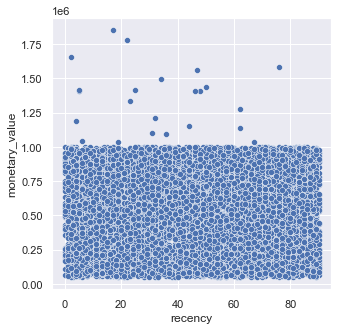

In [29]:
#Una muestra rápida de los ordenados por Monetary Value contra Recency
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='recency',y='monetary_value',data=tabla_rfm)
fig.show()

In [30]:
#Medias de recency, frequency, monetary_value por Segmento. 
tabla_rfm.groupby(['Segmento']).agg({'recency':np.mean,'frequency':np.mean,'monetary_value':np.mean,})

,recency,frequency,monetary_value
Segmento,,,
A punto de dormir,34.654694,1.000000,2.880527e+05
En riesgo,12.954545,2.000000,9.429737e+05
Leales,45.652174,2.000000,1.091691e+06
Leales potenciales,67.832123,1.000000,4.120908e+05
Otros,34.096767,1.000693,7.481100e+05
Perdidos,11.487382,1.000000,1.673375e+05


In [32]:
#Una muestra de la tabla Final. Feliz Análisis!
tabla_rfm.sample(10)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Segmento
CUSTOMER,,,,,,,
893752,13,1,752595,4,4,2,Otros
776577,51,1,383241,2,4,3,Leales potenciales
620324,87,1,174609,1,4,4,Leales potenciales
519581,33,1,257732,3,4,4,A punto de dormir
297041,39,1,143979,3,4,4,A punto de dormir
477961,55,1,718244,2,4,2,Leales potenciales
433576,7,1,923364,4,4,1,Otros
189274,44,1,777992,3,4,1,Otros
59073,23,1,534272,4,4,2,Otros


# Pero y qué pasa por la Categoria de Compra?

In [33]:
# Se crea una tabla agregada por categoria "Belleza", "Muebles", "Smartphones", "Herramientas", "Ropa", "Decoración"
condicion = df['CATEGORY'] == 'Belleza'

tabla = df[condicion].groupby('CUSTOMER').agg({
    'ORDER_DATE': lambda x: (fecha_hoy - x.max()).days, #Los días que han pasado desde la compra hasta hoy
    'ORDER_ID': lambda x: len(x.unique()), #La cantidad de Compras en el periodo
    'GRAND_TOTAL': lambda x: x.sum() #La Suma total de las compras
})

In [34]:
tabla.sample(10)

,ORDER_DATE,ORDER_ID,GRAND_TOTAL
CUSTOMER,,,
285734,73,1,576479
600107,83,1,785272
776389,60,1,971325
430591,54,1,581355
418622,31,1,296595
563435,39,1,229122
852330,64,1,983849
305871,52,1,411985
451658,0,1,909910


# Ejecuta el proceso de Scoring y Segmentación sobre la tabla condicionada antes del siguiente paso:

In [38]:
#Medias de recency, frequency, monetary_value por Segmento
tabla_rfm.groupby(['Segmento']).agg({'recency':np.mean,'frequency':np.mean,'monetary_value':np.mean,})

,recency,frequency,monetary_value
Segmento,,,
A punto de dormir,35.673367,1.0,296717.979899
Leales potenciales,69.649351,1.0,395419.831169
Otros,34.771622,1.0,744462.960811
Perdidos,11.823529,1.0,167084.781513
